In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from datetime import datetime
import threading

In [139]:
# Load an image from file
image_path = '../Datasets/Image-Data/20211230142000_11_NE.jpg'
image_path = '../Datasets/Image-Data/20211229105000_11_NE.jpg'

image = cv2.imread(image_path)

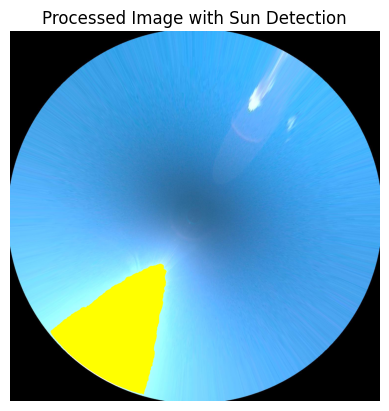

In [140]:
if image is None:
    print("Error: Unable to load the image.")
    exit()

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Apply GaussianBlur to reduce noise and help with contour detection
blurred = cv2.GaussianBlur(gray, (15, 15), 0)  # kernel size

# Use adaptive thresholding to create a binary image
_, thresh = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and find the contour with the largest area (assumed to be the sun)
largest_contour = max(contours, key=cv2.contourArea)

# Draw a yellow circle around the sun
cv2.drawContours(image, [largest_contour], -1, (0, 255, 255), -1)

# Display the result using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Processed Image with Sun Detection')
plt.axis('off')
plt.show()

In [141]:
# Check if the image was loaded successfully
max_th = 0
min_th = float('inf')
th_arr = []
if image is None:
    print("Error: Unable to load the image.")
    exit()

# Get image dimensions
height, width, _ = image.shape

center_x, center_y = width // 2, height // 2
radius = height // 2

# Create an empty output image
output_image = np.zeros_like(image)

# Iterate through each pixel in the image
for y in range(height):
    for x in range(width):
        # Get blue, green, and red intensity values for the current pixel
        b = float(image[y, x, 0])
        g = float(image[y, x, 1])
        r = float(image[y, x, 2])

        distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)

        # Avoid division by zero by adding a small epsilon value
        epsilon = 1e-5

        # Calculate the threshold value for the current pixel
        threshold = (b / (r + epsilon)) + (b / (g + epsilon))

        if b == 0 and r == 0 and g == 0: # Outside the circle
            threshold = 0
        if b == 0 and r == 255 and g == 255: # Sun
            threshold = -1

        # Define the threshold value
        threshold_value = 3.0  # You may adjust this value based on your image characteristics

        # Classify the pixel based on the threshold
        if radius < distance_to_center:
            output_image[y, x, :] = [0, 0, 0]
        elif threshold < 0:
            output_image[y, x, :] = [0, 255, 255]
        else:
            th_arr.append(threshold)
            if threshold > threshold_value:
                # Pixel is above the threshold, set it to blue
                output_image[y, x, :] = [255, 0, 0]
            else:
                # Pixel is below the threshold, set it to grey
                output_image[y, x, :] = [128, 128, 128]

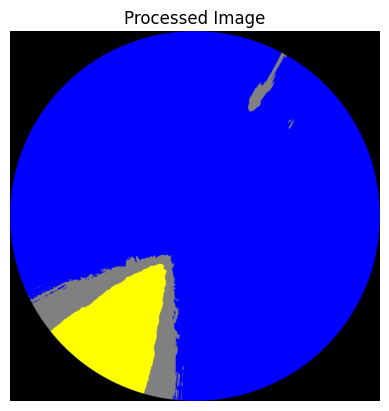

In [142]:
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('Processed Image')
plt.axis('off')
plt.show()

In [3]:
def find_sun(image_path):
    image = cv2.imread(image_path)

    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # # plt.title('Processed Image with Sun Detection')
    # plt.axis('off')
    # plt.show()

    if image is None:
        print("Error: Unable to load the image.")
        exit()

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Apply GaussianBlur to reduce noise and help with contour detection
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)  # kernel size

    # Use adaptive thresholding to create a binary image
    _, thresh = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Iterate through the contours and find the contour with the largest area (assumed to be the sun)
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        sun_coordinates, sun_radius = (x + w // 2, y + h // 2), max(w // 2, h // 2)

        if sun_radius < 50:
            sun_radius = 50
        if sun_radius > 100:
            sun_radius = 100

        # Draw a yellow circle around the sun
        cv2.circle(image, sun_coordinates, sun_radius, (0, 255, 255), thickness=-1)

    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # # plt.title('Processed Image with Sun Detection')
    # plt.axis('off')
    # plt.show()

    return image

In [4]:
def BRBG_segmentation(image_path):
    sun_image = find_sun(image_path)
    # Check if the image was loaded successfully
    sky = 0
    cloud = 0
    if sun_image is None:
        print("Error: Unable to load sun image.")
        exit()

    # Get image dimensions
    height, width, _ = sun_image.shape

    center_x, center_y = width // 2, height // 2
    radius = height // 2

    # Create an empty output image
    output_image = np.zeros_like(sun_image)

    # Iterate through each pixel in the image
    for y in range(height):
        for x in range(width):
            # Get blue, green, and red intensity values for the current pixel
            b = float(sun_image[y, x, 0])
            g = float(sun_image[y, x, 1])
            r = float(sun_image[y, x, 2])

            distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)

            # Avoid division by zero by adding a small epsilon value
            epsilon = 1e-5

            # Calculate the threshold value for the current pixel
            threshold = (b / (r + epsilon)) + (b / (g + epsilon))

            if b == 0 and r == 0 and g == 0: # Outside the circle
                threshold = 0
            if b == 0 and r == 255 and g == 255: # Sun
                threshold = -1

            # Define the threshold value
            threshold_value = 2.5  # You may adjust this value based on your image characteristics

            # Classify the pixel based on the threshold
            if radius < distance_to_center:
                output_image[y, x, :] = [0, 0, 0]
            elif threshold < 0:     
                sky += 1
                output_image[y, x, :] = [0, 255, 255]
            else:
                if threshold > threshold_value:
                    sky += 1
                    # Pixel is above the threshold, set it to blue
                    output_image[y, x, :] = [255, 34, 34]
                else:
                    cloud += 1
                    # Pixel is below the threshold, set it to grey
                    output_image[y, x, :] = [128, 128, 128]
    cloud_cover = (cloud/(sky+cloud)) * 100

    # Display the result using matplotlib
    # plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    # # plt.title('Processed Image with Sun Detection')
    # plt.axis('off')
    # plt.show()

    return output_image, cloud_cover

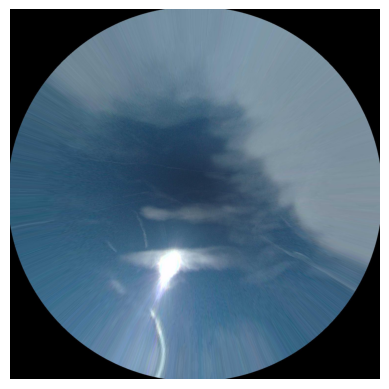

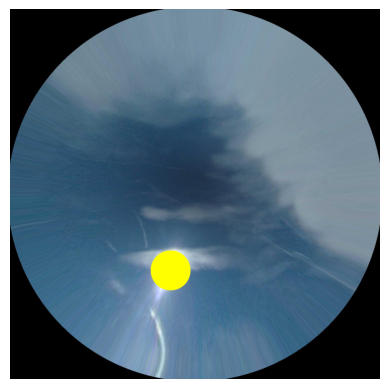

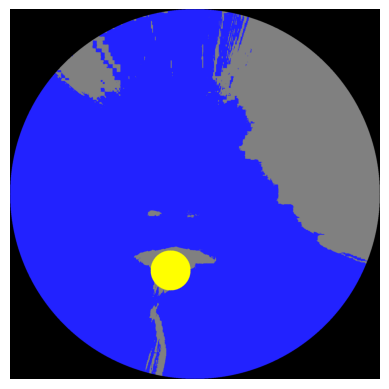

In [28]:
# Load an image from file
image_path = '../Datasets/Image-Data/20211229105000_12_UE.jpg'
image_path = '../Datasets/Image-Data/20211231163000_12_UE.jpg'
image_path = '../Datasets/Image-Data/2022/20220103132000_12_UE.jpg'

output_image, cloud_cover = BRBG_segmentation(image_path)

In [29]:
cloud_cover

24.667184646665397

In [200]:
os.mkdir("../Datasets/Image-Data/Segmented/hourly")

In [5]:
source_folder = "../Datasets/Image-Data/2021"
dest_folder = "../Datasets/Image-Data/Segmented/hourly/"

In [6]:
date_format = "%Y%m%d%H%M%S"
csv_file_path = '../Datasets/cloud_cover_hourly.csv'

In [7]:
file_list = []
for filename in os.listdir(source_folder):
    if "0000_12_UE" in filename:
        file_list.append(filename)

In [8]:
len(file_list)

3966

In [ ]:
for filename in file_list[6927:]:
    image_path = os.path.join(source_folder, filename)
    output_image, cloud_cover = BRBG_segmentation(image_path)
    dest_path = os.path.join(dest_folder, filename)
    cv2.imwrite(dest_path, output_image)
    date_string = filename.split("_")[0]
    date_object = datetime.strptime(date_string, date_format)
    date = date_object.strftime("%Y-%m-%d %H:%M:%S")
    with open(csv_file_path, 'a', newline='') as file:
        row = f"{date}\t{cloud_cover}\n"
        file.write(row)


In [32]:
def process_image(filename):
    image_path = os.path.join(source_folder, filename)
    output_image, cloud_cover = BRBG_segmentation(image_path)
    dest_path = os.path.join(dest_folder, filename)
    cv2.imwrite(dest_path, output_image)
    date_string = filename.split("_")[0]
    date_object = datetime.strptime(date_string, date_format)
    date = date_object.strftime("%Y-%m-%d %H:%M:%S")
    with open(csv_file_path, 'a', newline='') as file:
        row = f"{date}\t{cloud_cover}\n"
        file.write(row)

In [33]:
threads = []
for i, filename in enumerate(file_list[1582:]):
    thread = threading.Thread(target=process_image, args=(filename))
    threads.append(thread)

In [34]:
# Start the threads
for thread in threads:
    thread.start()

Exception in thread Thread-5 (process_image):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-6 (process_image):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-7 (process_image):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-8 (process_image):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
Exception in thread Thread-9 (process_image):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1009, in _bootstrap_i

KeyboardInterrupt: 

In [ ]:
# Wait for all threads to finish
for thread in threads:
    thread.join()